In [1]:
import plotly.express as px
import numpy as np
import nibabel as nib
from PIL import Image
import matplotlib.pyplot as plt
import os
import pandas as pd
import pickle
from glob import glob

import sys
sys.path.append('../../modified_medsam_repo')
from MedSAM_HCP.dataset import MRIDataset, load_datasets
from MedSAM_HCP.MedSAM import MedSAM, medsam_inference
from MedSAM_HCP.build_sam import build_sam_vit_b_multiclass
from MedSAM_HCP.utils_hcp import *

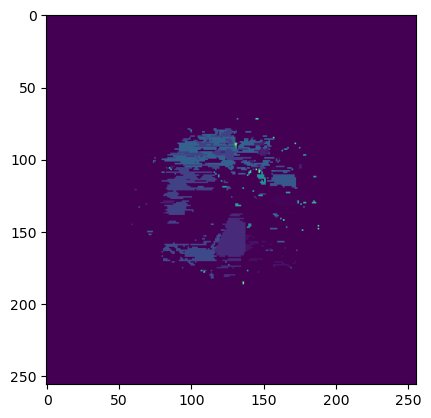

: 

In [11]:
xx = np.load('/gpfs/data/luilab/karthik/pediatric_seg_proj/results_copied_from_kn2347/brats_segmentations_9-17-24/unet/001/singletask_seg_all.npy')

In [ ]:
train_test_splits_path = '/gpfs/data/luilab/karthik/pediatric_seg_proj/train_val_test_split.pickle'
pd.read_pickle(train_test_splits_path)['test']

In [9]:
mri_raw_file_path = '/gpfs/data/luilab/karthik/MICCAI_BraTS2020_TrainingData/BraTS20_Training_001/BraTS20_Training_001_t1.nii.gz'
seg_arr = np.load('/gpfs/data/luilab/karthik/pediatric_seg_proj/results_copied_from_kn2347/brats_segmentations_9-17-24/001/singletask_seg_all.npy')
assert seg_arr.shape == (256,256,256)

In [8]:
np.random.seed(2023)
unqs = np.unique(seg_arr)
print(unqs)
rand_nums = np.random.random((len(unqs), 3))
color_label_mapper = dict()
for i in range(len(unqs)):
    color_label_mapper[unqs[i]] = (rand_nums[i, :] * 255).astype('uint8')


[  0   1   2   3   4   5   6   7   8  10  11  12  18  19  20  22  23  24
  25  28  29  30  31  35  38  40  41  42  44  45  46  47  48  49  50  51
  52  53  54  55  56  57  58  59  60  61  62  64  65  66  67  68  69  70
  72  73  75  76  77  79  80  81  83  85  86  87  88  89  90  91  92  93
  94  95  96  97  98  99 100 101]


In [11]:
df_hcp = pd.read_csv('/gpfs/home/kn2347/HCP_MedSAM_project/modified_medsam_repo/hcp_mapping_processed.csv')
df_desired = pd.read_csv('/gpfs/home/kn2347/HCP_MedSAM_project/modified_medsam_repo/darts_name_class_mapping_processed.csv')
NUM_CLASSES = len(df_desired)
label_converter = LabelConverter(df_hcp, df_desired)

In [ ]:
np.asarray(Image.open('/gpfs/data/luilab/karthik/MICCAI_BraTS2020_TrainingData/images/images001_slice120.png'))

In [25]:
# given a directory of the png's for the MRI, seg array and an roi number, plot an animation
def get_animation_imgs(mri_img_pattern, seg_arr, region_number, out_path):
    # load the MRI
    img_paths = glob(mri_img_pattern)
    color_vec = color_label_mapper[region_number] # (np array of 3)
    
    # 256,256,1 * 1,3

    # generate slice by slice
    img_list = []
    for slice_num in range(50,220):
        # first, start with the source mri image
        list_match = [s for s in img_paths if f'slice{slice_num}' in s]
        assert len(list_match) == 1
        
        this_slice_img = np.asarray(Image.open(list_match[0]))
        #this_slice_img = np.repeat(img[:,slice_num,:][:,:,None], 3, axis=-1)
        if region_number <= 0:
            # only output the raw scan as the image
            final_img = Image.fromarray(this_slice_img.astype('uint8'), 'RGB')
            img_list.append(final_img)
            continue

        #img_pil = Image.fromarray(this_slice_img, 'RGB')
        #img_pil.putalpha(200)
        
        # next, create a mask for the specific region number
        this_slice_mask = seg_arr[slice_num, :, :] == region_number
        this_slice_mask = np.repeat(this_slice_mask[:,:,None], 3, axis=-1) # 256,256,3

        color_portion = np.zeros((this_slice_mask.shape[0], this_slice_mask.shape[1], 3))
        #mask_uint8 = np.dstack((color_portion, this_slice_mask*0.5*255)).astype('uint8')
        
        for i in range(3):
            color_portion[:,:,i] = color_vec[i]
        

        mask_colored = this_slice_mask * color_portion # has 0s if not active at that pixel, and the right color value if it is
        # but we need to grab all the 0s and set them to the source value

        mask_colored[np.where(this_slice_mask==0)] = this_slice_img[np.where(this_slice_mask==0)]

        # form a linear combination
        delta = 0.7
        final = delta * mask_colored + (1-delta) * this_slice_img

        final_img = Image.fromarray(final.astype('uint8'), 'RGB')

        img_list.append(final_img)
    
    img_list[0].save(os.path.join(out_path, f'{label_converter.compressed_to_name(region_number)}.gif'), format='GIF', save_all=True, append_images = img_list[1:],
                    duration=100, loop=0)




mri_img_pattern = '/gpfs/data/luilab/karthik/MICCAI_BraTS2020_TrainingData/images/images001_slice*.png'
for i in range(0, 103):
    if i in np.unique(seg_arr):
        get_animation_imgs(mri_img_pattern, seg_arr, i, out_path = '/gpfs/data/luilab/karthik/pediatric_seg_proj/results_copied_from_kn2347/brats_segmentations_9-17-24/region_animations/001')

In [13]:
# given an original nib file, seg array and an roi number, plot an animation
def get_animation(mri_file_path, seg_arr, region_number, out_path):
    # load the MRI
    img = nib.load(mri_file_path).get_fdata().astype(np.uint8)
    color_vec = color_label_mapper[region_number] # (np array of 3)
    
    # 256,256,1 * 1,3

    # generate slice by slice
    img_list = []
    for slice_num in range(50,220):
        # first, start with the source mri image
        this_slice_img = np.repeat(img[:,slice_num,:][:,:,None], 3, axis=-1)
        if region_number <= 0:
            # only output the raw scan as the image
            final_img = Image.fromarray(this_slice_img.astype('uint8'), 'RGB')
            img_list.append(final_img)
            continue

        #img_pil = Image.fromarray(this_slice_img, 'RGB')
        #img_pil.putalpha(200)
        
        # next, create a mask for the specific region number
        this_slice_mask = seg_arr[slice_num, :, :] == region_number
        this_slice_mask = np.repeat(this_slice_mask[:,:,None], 3, axis=-1) # 256,256,3

        color_portion = np.zeros((this_slice_mask.shape[0], this_slice_mask.shape[1], 3))
        #mask_uint8 = np.dstack((color_portion, this_slice_mask*0.5*255)).astype('uint8')
        
        for i in range(3):
            color_portion[:,:,i] = color_vec[i]
        

        mask_colored = this_slice_mask * color_portion # has 0s if not active at that pixel, and the right color value if it is
        # but we need to grab all the 0s and set them to the source value

        mask_colored[np.where(this_slice_mask==0)] = this_slice_img[np.where(this_slice_mask==0)]

        # form a linear combination
        delta = 0.7
        final = delta * mask_colored + (1-delta) * this_slice_img

        final_img = Image.fromarray(final.astype('uint8'), 'RGB')

        img_list.append(final_img)
    
    img_list[0].save(os.path.join(out_path, f'{label_converter.compressed_to_name(region_number)}.gif'), format='GIF', save_all=True, append_images = img_list[1:],
                    duration=100, loop=0)




for i in range(0, 2):
    if i in np.unique(seg_arr):
        get_animation(mri_raw_file_path, seg_arr, i, out_path = '/gpfs/data/luilab/karthik/pediatric_seg_proj/results_copied_from_kn2347/brats_segmentations_9-17-24/region_animations/001')

(256, 256, 3)


IndexError: index 240 is out of bounds for axis 0 with size 240

In [85]:
# fuse together all regions to get an animation
def get_animation_fused(mri_file_path, seg_arr, out_path):
    # load the MRI
    img = nib.load(mri_file_path).get_fdata().astype(np.uint8)

    # 256,256,1 * 1,3

    # generate slice by slice
    img_list = []
    delta = 0.7
    for slice_num in range(50,220):
        # first, start with the source mri image
        this_slice_img = np.repeat(img[:,slice_num,:][:,:,None], 3, axis=-1)

        #img_pil = Image.fromarray(this_slice_img, 'RGB')
        #img_pil.putalpha(200)
        

        # next, create a mask for each specific region number
        num_regions = len(np.unique(seg_arr[slice_num, :, :]))
        color_portion = this_slice_img # 256,256,3
        for region_number in np.unique(seg_arr[slice_num, :, :]):
            if region_number==0:
                continue
            color_vec = color_label_mapper[region_number]
            this_slice_mask = seg_arr[slice_num, :, :] == region_number
            this_slice_mask = np.repeat(this_slice_mask[:,:,None], 3, axis=-1) # 256,256,3

            #mask_uint8 = np.dstack((color_portion, this_slice_mask*0.5*255)).astype('uint8')
            color_tmper = np.zeros((256,256,3))
            for i in range(3):
                color_tmper[:,:,i] = color_vec[i]
            

            mask_colored = this_slice_mask * color_tmper # has 0s if not active at that pixel, and the right color value if it is
            # but we need to grab all the 0s and set them to the source value
            color_portion[np.where(this_slice_mask==1)] = mask_colored[np.where(this_slice_mask==1)]
            #mask_colored[np.where(this_slice_mask==0)] = this_slice_img[np.where(this_slice_mask==0)]

        final_array = (1-delta)*this_slice_img + delta * color_portion
        final_img = Image.fromarray(final_array.astype('uint8'), 'RGB')

        img_list.append(final_img)
    
    img_list[0].save(os.path.join(out_path, 'fused.gif'), format='GIF', save_all=True, append_images = img_list[1:],
                    duration=100, loop=0)

get_animation_fused(mri_raw_file_path, seg_arr, out_path = '/gpfs/data/luilab/karthik/pediatric_seg_proj/saved_round2_segmentations/151425_upd')